In [ ]:
# Detectron2 설치
!pip install -q detectron2

# 필요한 라이브러리 임포트
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
# 한글 폰트 설정
!apt-get install -y fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_manager.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


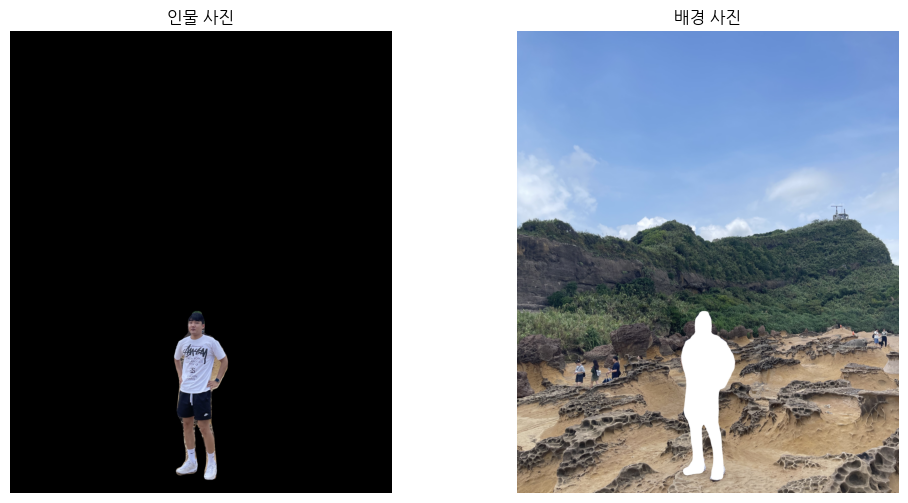

이미지들이 Colab 좌측 파일 탐색기에 저장되었습니다.


In [ ]:
# 모델 설정
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # 인식 임계값 설정
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Predictor 생성
predictor = DefaultPredictor(cfg)

# 이미지 경로 지정
image_path = "/content/KakaoTalk_20240128_174309684.jpg"
image = cv2.imread(image_path)

# Instance Segmentation 수행
outputs = predictor(image)

# 출력 정보 확인 (인스턴스별 마스크, 클래스 등)
instances = outputs["instances"]

# 'person' 클래스는 COCO 데이터셋에서 class 0
person_class = 0
person_masks = instances.pred_masks[instances.pred_classes == person_class].cpu().numpy()

# 여러 사람이 있을 경우 첫 번째 인물 마스크 사용 (필요에 따라 수정 가능)
if len(person_masks) > 0:
    person_mask = person_masks[0]  # 첫 번째 인물의 마스크

    # 인물 사진: 원본 이미지에서 사람만 남기고 나머지 부분을 검정색으로 처리
    person_image = image.copy()
    person_image[person_mask == False] = 0

    # 배경 사진: 원본 이미지에서 사람 부분을 흰색으로 처리
    background_image = image.copy()
    background_image[person_mask == True] = 255

    # 시각화용 이미지 크기 조정
    scale_percent = 30  # 이미지를 30%로 축소
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    # 인물과 배경 사진 모두 크기 조정
    resized_person_image = cv2.resize(person_image, dim, interpolation=cv2.INTER_AREA)
    resized_background_image = cv2.resize(background_image, dim, interpolation=cv2.INTER_AREA)

    # matplotlib을 사용하여 두 이미지를 한 행에 나란히 출력
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(resized_person_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("인물 사진")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(resized_background_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title("배경 사진")
    axes[1].axis("off")

    plt.show()

    # 인물 사진과 배경 사진 저장
    person_image_path = "/content/person_image.png"
    background_image_path = "/content/background_image.png"
    cv2.imwrite(person_image_path, person_image)
    cv2.imwrite(background_image_path, background_image)

    print("이미지들이 Colab 좌측 파일 탐색기에 저장되었습니다.")
else:
    print("사람을 감지하지 못했습니다.")

GrabCut 알고리즘 적용:

Detectron2의 **person_mask**를 초기 마스크로 사용하여 GrabCut을 적용합니다.
grabcut_mask를 사용하여 이미지에서 배경과 전경을 더 정확히 구분합니다.
마스크 후처리:

GrabCut을 5번 반복 수행한 후, 최종 마스크를 이용해 이미지의 경계를 더 정밀하게 분리합니다.

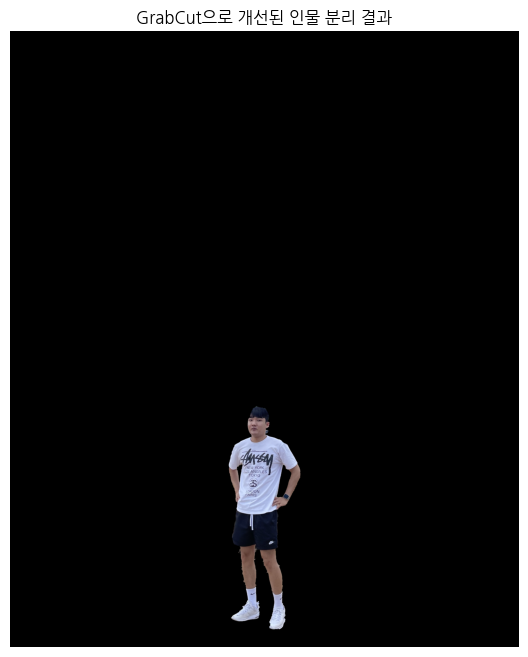

GrabCut으로 개선된 이미지가 Colab 좌측 파일 탐색기에 저장되었습니다.


In [ ]:
# 모델 설정
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # 인식 임계값 설정
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Predictor 생성
predictor = DefaultPredictor(cfg)

# 이미지 경로 지정
image_path = "/content/KakaoTalk_20240128_174309684.jpg"
image = cv2.imread(image_path)

# Instance Segmentation 수행
outputs = predictor(image)

# 출력 정보 확인 (인스턴스별 마스크, 클래스 등)
instances = outputs["instances"]

# 'person' 클래스는 COCO 데이터셋에서 class 0
person_class = 0
person_masks = instances.pred_masks[instances.pred_classes == person_class].cpu().numpy()

# 여러 사람이 있을 경우 첫 번째 인물 마스크 사용 (필요에 따라 수정 가능)
if len(person_masks) > 0:
    person_mask = person_masks[0]  # 첫 번째 인물의 마스크

    # 마스크를 기반으로 GrabCut을 적용하여 더 세밀한 경계 추출
    # 0: 배경, 1: 확실한 배경, 2: 확실한 전경, 3: 전경
    grabcut_mask = np.zeros(image.shape[:2], np.uint8)
    grabcut_mask[person_mask == False] = cv2.GC_BGD  # 배경
    grabcut_mask[person_mask == True] = cv2.GC_PR_FGD  # 전경 (확실하지 않은 전경)

    # GrabCut을 위한 모델
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # GrabCut 실행
    cv2.grabCut(image, grabcut_mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

    # 확실한 전경과 불확실한 전경 픽셀은 남기고 나머지는 제거
    grabcut_mask_final = np.where((grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')

    # GrabCut 적용된 최종 이미지
    grabcut_output = image * grabcut_mask_final[:, :, np.newaxis]

    # 결과 이미지 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(grabcut_output, cv2.COLOR_BGR2RGB))
    plt.title("GrabCut으로 개선된 인물 분리 결과")
    plt.axis("off")
    plt.show()

    # GrabCut으로 개선된 이미지 저장
    grabcut_image_path = "/content/grabcut_person_image.png"
    cv2.imwrite(grabcut_image_path, grabcut_output)

    print("GrabCut으로 개선된 이미지가 Colab 좌측 파일 탐색기에 저장되었습니다.")
else:
    print("사람을 감지하지 못했습니다.")